# Прогнозирование оттока клиентов 

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Необходимо построить модель для решения задачи классификации, которая определит: планирует ли клиент уйти. 

Изучим данные, по необходимости подготовим их для исследования. Построим модель с максимально большим значением *AUC-ROC*. Для успешного решения задачи доведем значение метрики по крайней мере до 0.85. 

## Знакомство с файлом

In [1]:
#Скачаем библиотеки
!pip install phik

In [2]:
!pip install scikit-learn==1.1.3

In [3]:
!pip3 install catboost

In [4]:
!!pip install lightgbm

['Requirement already satisfied: lightgbm in c:\\programdata\\anaconda3\\lib\\site-packages (4.0.0)',
 'Requirement already satisfied: scipy in c:\\programdata\\anaconda3\\lib\\site-packages (from lightgbm) (1.9.1)',
 'Requirement already satisfied: numpy in c:\\programdata\\anaconda3\\lib\\site-packages (from lightgbm) (1.24.3)']

In [5]:
#Подключим необходимые библиотеки
import re 
import phik
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

RANDOM_STATE = 140823

In [6]:
#Поочередно откроем и изучим таблицы
contract = pd.read_csv('/Users/Varvara/Documents/dataset/contract_new.csv')
personal = pd.read_csv('/Users/Varvara/Documents/dataset/personal_new.csv')
internet = pd.read_csv('/Users/Varvara/Documents/dataset/internet_new.csv')
phone = pd.read_csv('/Users/Varvara/Documents/dataset/phone_new.csv')

data_list = [contract, personal, internet, phone]
for data in data_list:
    display(data.head())
    display(data.describe())
    display(data.info())
    print('________________________________________________________________________________')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

________________________________________________________________________________


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

________________________________________________________________________________


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

________________________________________________________________________________


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

________________________________________________________________________________


**Выводы**

Данные предоставлены в 4 таблицах. Таблицы contract_new и personal_new содержат по 7043 строки без пропусков. В internet_new содержится 5517 строк без пропусков.  В таблице phone_new 6361 строка без пропущенных значений. Неправильно определен тип данных у столбца TotalCharges, названия столбцов не соответсвуют хорошему стилю.

## Предобработка данных

In [7]:
#Проверим данные на наличие явных дубликатов
for data in data_list:
    display(data.duplicated().sum())

0

0

0

0

In [8]:
#Приведем названия столбцов в соответсвие хорошему стилю
for data in data_list:
    data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in data.columns]
    data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_i_d       7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_i_d    7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null

In [9]:
internet = internet.rename(columns={'streaming_t_v':'streaming_tv'})
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_i_d       5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [10]:
#Объединим таблицы в одну
full = personal.merge(contract, how = 'left', on = 'customer_i_d')\
                          .merge(internet, how = 'left', on = 'customer_i_d')\
                          .merge(phone, how = 'left', on = 'customer_i_d')
full.head()

,customer_i_d,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Fiber optic,No,No,No,No,No,No,No


In [11]:
#Проверим, что после объединения количество строк осталось максимальным заодно поправим название первого столбца
full = full.rename(columns={'customer_i_d':'customer_id'})
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   gender             7043 non-null   object 
 2   senior_citizen     7043 non-null   int64  
 3   partner            7043 non-null   object 
 4   dependents         7043 non-null   object 
 5   begin_date         7043 non-null   object 
 6   end_date           7043 non-null   object 
 7   type               7043 non-null   object 
 8   paperless_billing  7043 non-null   object 
 9   payment_method     7043 non-null   object 
 10  monthly_charges    7043 non-null   float64
 11  total_charges      7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

В столбце total_charges были пустые значения, с ними поменять тип данных было невозможно, поэтому мы заменили их на NaN. В столбце end_date были даты и значение No, для корректной смены типа данных, была произведена замена таких значений на последний день выгрузки датасета - 1 февраля 2020. Для удобства работы с данными ввели столбец is_client - отражающий целевой признак:

In [12]:
#Заменим No на '2020-02-01' в end_date и обозначим новый столбец is_client
full['end_date'] = full['end_date'].replace('No', '2020-02-01')
full['is_client'] = full['end_date'].apply(lambda x: 1 if x == '2020-02-01' else 0)

In [13]:
#Изменим тип данных столбцов total_charges, senior_citizen, begin_date и end_date
full['total_charges'] = pd.to_numeric(full['total_charges'], errors = 'coerce') 
full['senior_citizen'] = full['senior_citizen'].astype('object')

full['begin_date'] = pd.to_datetime(full['begin_date'], format='%Y-%m-%d')
full['end_date'] = pd.to_datetime(full['end_date'], format='%Y-%m-%d')
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   gender             7043 non-null   object        
 2   senior_citizen     7043 non-null   object        
 3   partner            7043 non-null   object        
 4   dependents         7043 non-null   object        
 5   begin_date         7043 non-null   datetime64[ns]
 6   end_date           7043 non-null   datetime64[ns]
 7   type               7043 non-null   object        
 8   paperless_billing  7043 non-null   object        
 9   payment_method     7043 non-null   object        
 10  monthly_charges    7043 non-null   float64       
 11  total_charges      7032 non-null   float64       
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

Для заполнения пропусков в total_charges было принято решение взять данные из monthly_charges, так как скорее всего это новые пользователи, которые пока немного пользуются услугами. В остальных столбцах для корректной разметки в будующем вместо пропусков введены значения No_internet и No_phone для соответсвующих строк.

In [14]:
#Заполним пропуски, где это возможно
full['total_charges'] = full['total_charges'].fillna(full['monthly_charges'])
full['internet_service'] = full['internet_service'].fillna('No_internet')
full['online_security'] = full['online_security'].fillna('No_internet')
full['online_backup'] = full['online_backup'].fillna('No_internet')
full['device_protection'] = full['device_protection'].fillna('No_internet')
full['tech_support'] = full['tech_support'].fillna('No_internet')
full['streaming_tv'] = full['streaming_tv'].fillna('No_internet')
full['streaming_movies'] = full['streaming_movies'].fillna('No_internet')
full['multiple_lines'] = full['multiple_lines'].fillna('No_phone')
                              
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   gender             7043 non-null   object        
 2   senior_citizen     7043 non-null   object        
 3   partner            7043 non-null   object        
 4   dependents         7043 non-null   object        
 5   begin_date         7043 non-null   datetime64[ns]
 6   end_date           7043 non-null   datetime64[ns]
 7   type               7043 non-null   object        
 8   paperless_billing  7043 non-null   object        
 9   payment_method     7043 non-null   object        
 10  monthly_charges    7043 non-null   float64       
 11  total_charges      7043 non-null   float64       
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

**Выводы**

В ходе предобработки данных явных дубликатов не выявлено. Названия столбцов приведены в соответсвие с хорошим стилем. 

Для дальнейшего исследования данных, таблицы были объедены в одну по столбцу customer_id. Количество строк в общей таблице соответвует наибольшему количеству строк из 4 таблиц (таблица contract). 

Типы данных некоторых столбцов были изменены: total_charges переведен в float64,senior_citizen в object, begin_date и end_date в datetime64.  Для удобства работы с данными ввели столбец is_client - отражающий целевой признак: остался клиент или ушел. В ходе объединения таблиц появились пропуски. Они были заполнены значениями, исходя из назначения столбца. Заполнение пропусков необходимо для повышения качества будующих моделей и корректной разметки данных в исследовательском анализе. 

## Исследовательский анализ данных

Создадим дополнительные столбцы с длительностью контракта в днях, количеством дополнительных услуг:

In [15]:
full['duration_contract_days'] = (full['end_date'] -  full['begin_date']).dt.days

cols=['online_security','online_backup','device_protection','tech_support','streaming_tv','streaming_movies']
full['num_services']=(full[cols]=='Yes').sum(axis=1)
full.head()

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,...,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,is_client,duration_contract_days,num_services
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,...,No,Yes,No,No,No,No,No_phone,1,31,1
1,5575-GNVDE,Male,0,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,...,Yes,No,Yes,No,No,No,No,1,1036,2
2,3668-QPYBK,Male,0,No,No,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,...,Yes,Yes,No,No,No,No,No,1,123,2
3,7795-CFOCW,Male,0,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),...,Yes,No,Yes,Yes,No,No,No_phone,1,1371,3
4,9237-HQITU,Female,0,No,No,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,...,No,No,No,No,No,No,No,1,153,0


Удалим столбец 'customer_id', так как он уникальный и неколичественный. Удалим столбцы 'begin_date' и 'end_date', так как на их основе уже был создан более показательный 'duration_contract_days'.

In [16]:
full.drop(['customer_id', 'begin_date', 'end_date'], axis= 1 , inplace= True ) 

In [17]:
#Проверим численные признаки на мультиколлинеарность
full_corr = full.copy()
full_corr.drop(['is_client'], axis= 1 , inplace= True )

corr = full_corr.corr().round(3)
corr.style.background_gradient(cmap='coolwarm')

,monthly_charges,total_charges,duration_contract_days,num_services
monthly_charges,1.000000,0.630000,0.220000,0.725000
total_charges,0.630000,1.000000,0.822000,0.711000
duration_contract_days,0.220000,0.822000,1.000000,0.450000
num_services,0.725000,0.711000,0.450000,1.000000


Возьмем пороговое значение коллинеарности 0.6. Столбец monthly_charges и total_charges сильно коррелируют со столбцами num_services и duration_contract_days, поэтому их необходимо удалить.

In [18]:
#Удалим столбец 'total_charges'
full.drop(['total_charges', 'monthly_charges'], axis= 1 , inplace= True)  

In [19]:
#Проверим категориальные признаки на мультиколлинеарность
interval_columns = ['num_services','duration_contract_days']

corr_2 = full.phik_matrix(interval_cols = interval_columns)
corr_2.style.background_gradient(cmap='coolwarm')

,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,is_client,duration_contract_days,num_services
gender,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008581,0.000000,0.000000
senior_citizen,0.000000,1.000000,0.016992,0.324576,0.086231,0.242133,0.292725,0.160702,0.127319,0.109995,0.110177,0.135283,0.111714,0.113778,0.087925,0.086159,0.063315,0.122972
partner,0.000000,0.016992,1.000000,0.652122,0.179736,0.013218,0.243008,0.000000,0.091202,0.092012,0.100092,0.076326,0.082251,0.077506,0.086249,0.226688,0.453688,0.209510
dependents,0.000000,0.324576,0.652122,1.000000,0.147680,0.172593,0.224903,0.108463,0.117219,0.097766,0.094597,0.109753,0.088193,0.084684,0.011198,0.046871,0.198729,0.114160
type,0.000000,0.086231,0.179736,0.147680,1.000000,0.106860,0.277462,0.505187,0.636884,0.581660,0.631531,0.671629,0.549564,0.553556,0.244410,0.094015,0.634155,0.484338
paperless_billing,0.000000,0.242133,0.013218,0.172593,0.106860,1.000000,0.370495,0.231438,0.208320,0.195321,0.195687,0.200621,0.204717,0.202241,0.099953,0.083398,0.026799,0.235657
payment_method,0.000000,0.292725,0.243008,0.224903,0.277462,0.370495,1.000000,0.323886,0.315799,0.293413,0.297923,0.317713,0.284531,0.285525,0.174849,0.214832,0.350964,0.311522
internet_service,0.000000,0.160702,0.000000,0.108463,0.505187,0.231438,0.323886,1.000000,0.949498,0.942842,0.942811,0.948914,0.946713,0.946294,0.739808,0.056621,0.060845,0.647446
online_security,0.001460,0.127319,0.091202,0.117219,0.636884,0.208320,0.315799,0.949498,1.000000,0.947224,0.946787,0.952651,0.943082,0.943248,0.540261,0.058659,0.346398,0.715011
online_backup,0.000000,0.109995,0.092012,0.097766,0.581660,0.195321,0.293413,0.942842,0.947224,1.000000,0.947487,0.947756,0.945789,0.945395,0.562933,0.089704,0.366170,0.719790


Столбец dependents коррелирует с partner, type с рядом других столбцов, столбцы internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies коррелируют с num_services. Удалим корреляционные столбцы:

In [20]:
full.drop(['dependents', 'type', 'internet_service', 'online_security', 'online_backup',
           'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies'],
          axis= 1 , inplace= True ) 

In [21]:
#Проверим повторно численные признаки на мультиколлинеарность
full_corr = full.copy()
full_corr.drop(['is_client'], axis= 1 , inplace= True)
corr_3 = full.corr().round(3)
corr_3.style.background_gradient(cmap='coolwarm')

,is_client,duration_contract_days,num_services
is_client,1.000000,-0.017000,-0.184000
duration_contract_days,-0.017000,1.000000,0.450000
num_services,-0.184000,0.450000,1.000000


In [22]:
#Проверим повторно категориальные признаки на мультиколлинеарность
interval_columns = ['num_services', 'duration_contract_days']
 
corr_4 = full.phik_matrix(interval_cols = interval_columns)
corr_4.style.background_gradient(cmap='coolwarm')

,gender,senior_citizen,partner,paperless_billing,payment_method,multiple_lines,is_client,duration_contract_days,num_services
gender,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008581,0.000000,0.000000
senior_citizen,0.000000,1.000000,0.016992,0.242133,0.292725,0.087925,0.086159,0.063315,0.122972
partner,0.000000,0.016992,1.000000,0.013218,0.243008,0.086249,0.226688,0.453688,0.209510
paperless_billing,0.000000,0.242133,0.013218,1.000000,0.370495,0.099953,0.083398,0.026799,0.235657
payment_method,0.000000,0.292725,0.243008,0.370495,1.000000,0.174849,0.214832,0.350964,0.311522
multiple_lines,0.000000,0.087925,0.086249,0.099953,0.174849,1.000000,0.105101,0.347289,0.355873
is_client,0.008581,0.086159,0.226688,0.083398,0.214832,0.105101,1.000000,0.374569,0.182556
duration_contract_days,0.000000,0.063315,0.453688,0.026799,0.350964,0.347289,0.374569,1.000000,0.424428
num_services,0.000000,0.122972,0.209510,0.235657,0.311522,0.355873,0.182556,0.424428,1.000000


1    5942
0    1101
Name: is_client, dtype: int64

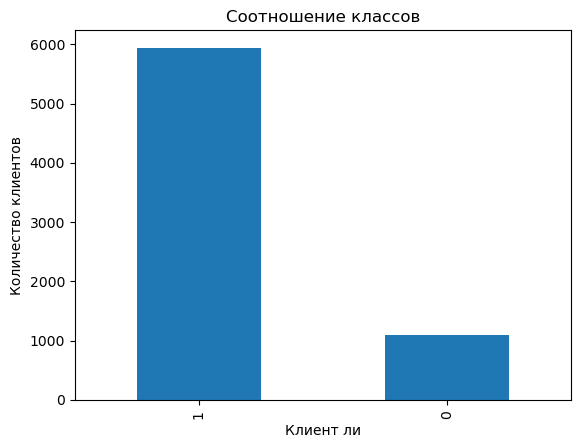

In [23]:
#Исследуем балланс классов в целевом признаке
full['is_client'].value_counts().plot(kind = 'bar', title='Соотношение классов')
plt.ylabel('Количество клиентов')
plt.xlabel('Клиент ли')
full['is_client'].value_counts()

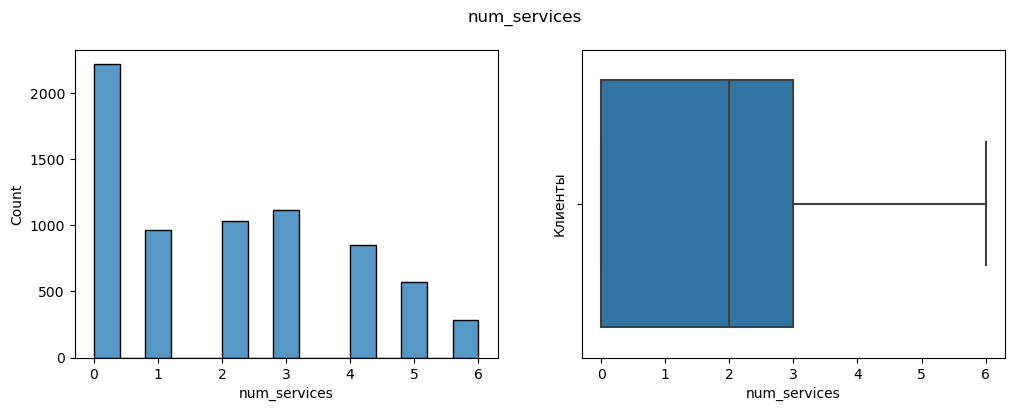

_________________________________________________________________________________________________________________


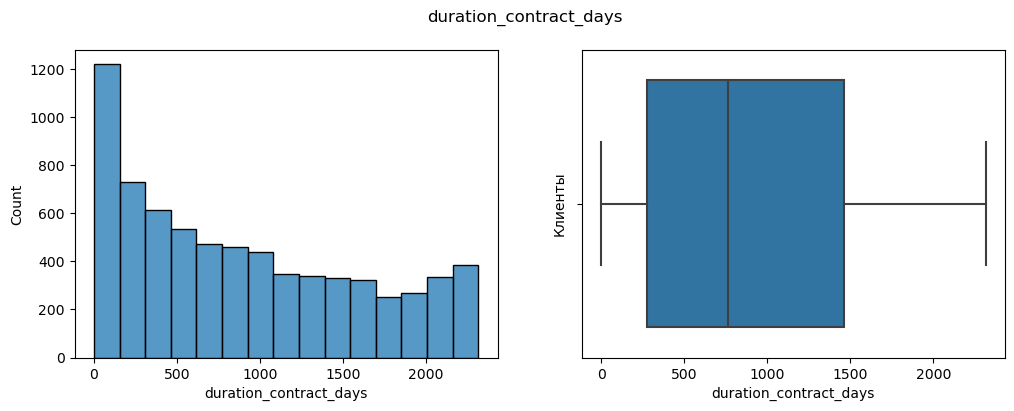

_________________________________________________________________________________________________________________


In [24]:
#Посмотрим на распределение численных признаков
cols = ['num_services', 'duration_contract_days']

for col in cols:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(full[col], bins = 15, ax = ax[0])
    plt.ylabel('Клиенты')
    sns.boxplot(x = full[col], ax=ax[1])
    fig.suptitle(col, size = 12)
    plt.show()
    print('_________________________________________________________________________________________________________________')

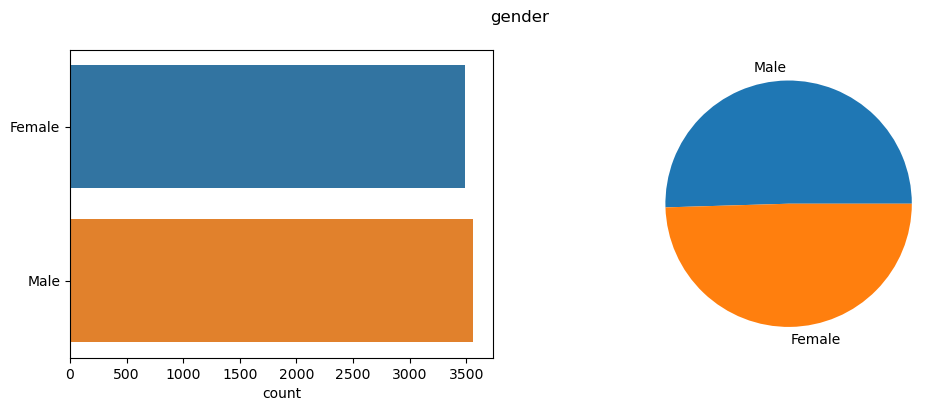

_________________________________________________________________________________________________________________


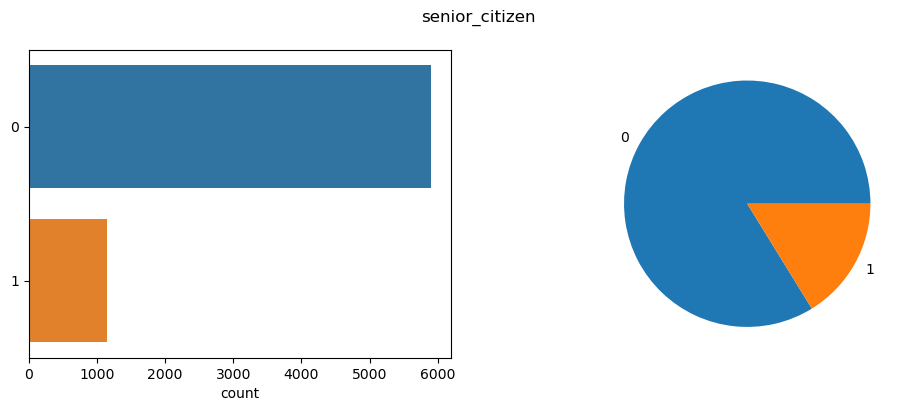

_________________________________________________________________________________________________________________


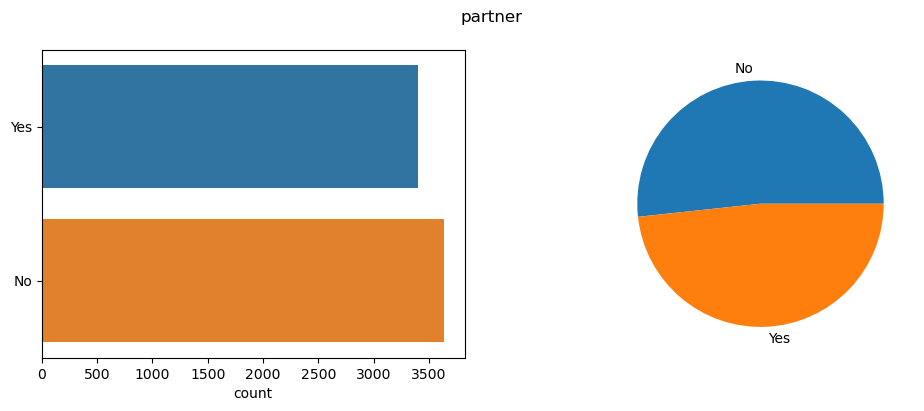

_________________________________________________________________________________________________________________


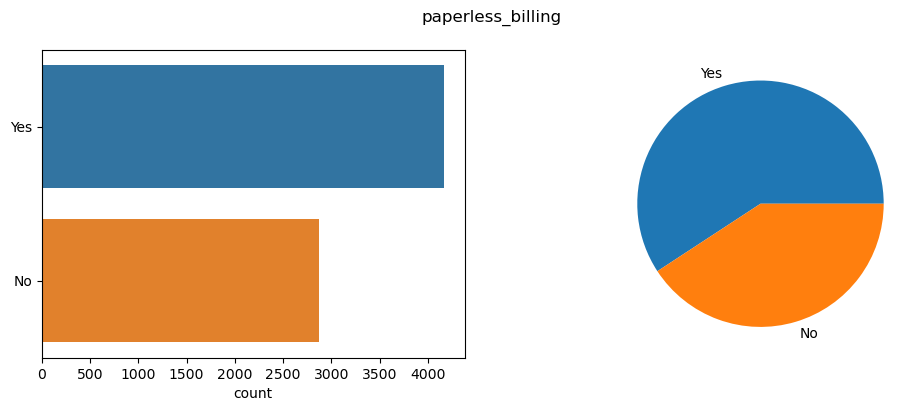

_________________________________________________________________________________________________________________


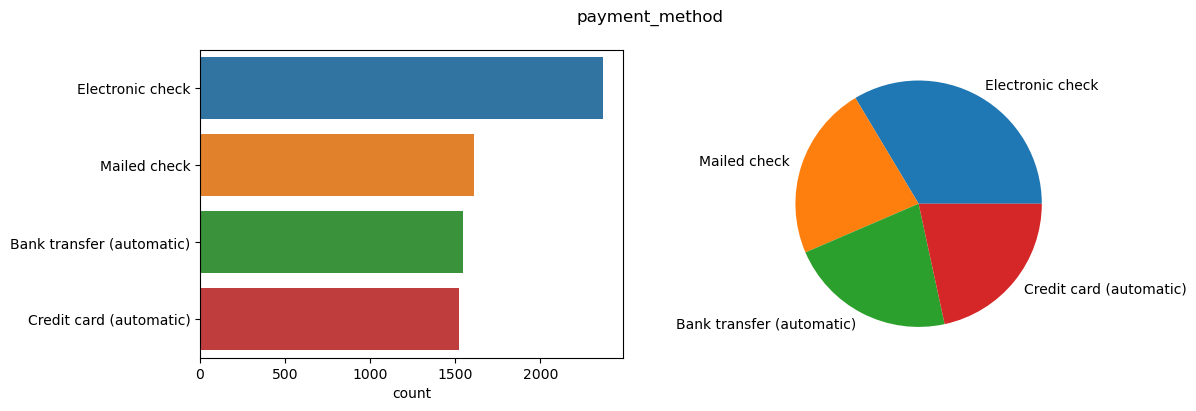

_________________________________________________________________________________________________________________


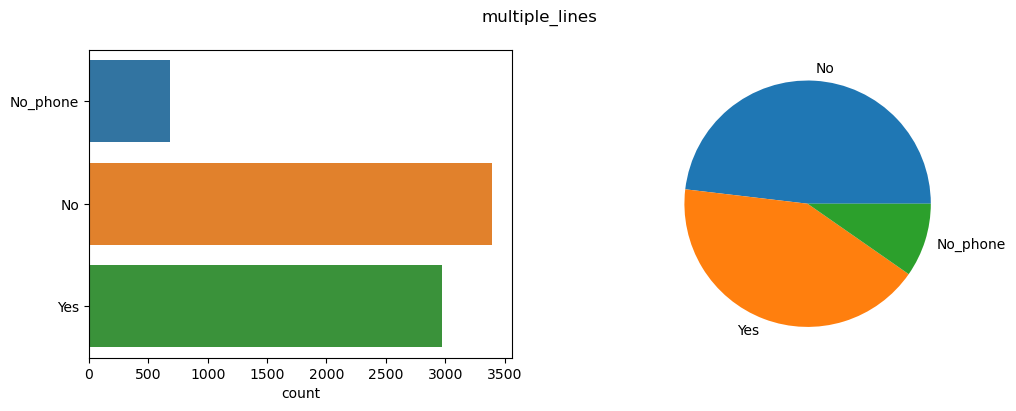

_________________________________________________________________________________________________________________


In [25]:
#Посмотрим на распределение категориальных признаков
cols = ['gender', 'senior_citizen', 'partner', 'paperless_billing', 'payment_method', 'multiple_lines']

for col in cols:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.countplot(data = full, y = full[col], ax=ax[0])
    full[col].value_counts().plot(kind = 'pie', ax=ax[1])
    fig.suptitle(col, size = 12)
    ax[0].set_ylabel('')
    ax[1].set_ylabel('')
    plt.show()
    print('_________________________________________________________________________________________________________________')

**Выводы**

В ходе исследовательского анализа данных были добавлены дополнительные столбцы с длительностью контракта в днях - duration_contract_days и количеством дополнительных услуг - num_services. Для улучшения обучения моделей были удалены столбцы:'customer_id', так как он уникальный и неколичественный, 'begin_date' и 'end_date', так как на их основе уже был создан более показательный 'duration_contract_days'.

Мы проанализировали взаимосвязь признаков на предмет мультиколлиниарности. Пороговое значение сильной коллинеарности приняли 0.6. Из численных признаков monthly_charges и total_charges сильно коррелируют со столбцами num_services и duration_contract_days, поэтому был удален. Из категориальных признаков dependents коррелировал с partner, type с рядом других столбцов, столбцы internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies - с num_services. Данные столбцы были также удалены.

Рассмотрели балланс классов в целевом признаке. На 6 текущих клиентов приходится 1 ушедший. Дисбаланс не требует выравнивания, так как ключевая метрика AUC-ROC не чувствительна к дисбалансу.

Изучили распределение численных признаков: num_services и duration_contract_days. Аномалий не выявлено. Около 1/3 пользователей не использует доп.услуг,чуть меньше 2/3 клиентов используют 1-4 доп сервиса и небольшая часть клиентов использует 5-6 дополнительных услуг. В столбце duration_contract_days наблюдается наблюдается большое количество пользователей с маленькой длительностью котракта. С увеличением длительности контракта количество пользователей снижается и в конце на самом большом количестве дней чуть-чуть увеличивается. Скорее всего это связано с большим количеством привлеченных пользователей вначале существования мобильного оператора. 

В результате изучения категориальных признаков стало ясно: мужчин и женщин в выборке примерно по ровну; преобладают трудоспособные люди перед пенсионерами - примерно 6 к 1; в отношения состоят приблизительно половина пользователей; почти 2/3 клиентов предпочитают получать чеки в электронном виде; среди систем оплаты лидируют эллектронные чеки - около 35% клиентов предпочитают их, на остальные способы приходится приблизительно по 20% клиентов. Около 8% пользователей не имеют телефона, остальные клиенты поровну предпочитают использовать/не использовать возможность ведения параллельных линий при звонке.

## Подготовим данные для обучения моделей

In [26]:
#Разделим данные на обучающую и тестовую выборки. Для тестовой выделим 25% данных:
data_train, data_test = train_test_split(full, test_size=0.25, random_state=RANDOM_STATE)

print(data_train.shape)
data_test.shape

(5282, 9)


(1761, 9)

In [27]:
#Подготовим признаки для исходных данных
features_train = data_train.drop(['is_client'], axis=1)
target_train = data_train['is_client']
features_test = data_test.drop(['is_client'], axis=1)
target_test = data_test['is_client']

In [28]:
#Подготовим категориальные признаки из тренировочной выборки для ohe
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
ohe_features

['gender',
 'senior_citizen',
 'partner',
 'paperless_billing',
 'payment_method',
 'multiple_lines']

In [29]:
#Подготовим численные признаки из тренировочной выборки для ohe
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features

['duration_contract_days', 'num_services']

In [30]:
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

In [31]:
#Переведем категориальные признаки в целочисленные, чтобы дальше обучать по ним модели
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)

encoder_ohe.fit(features_train_ohe[ohe_features])

features_train_ohe[
    encoder_ohe.get_feature_names_out()
]= encoder_ohe.transform(features_train_ohe[ohe_features])

features_train_ohe = features_train_ohe.drop(ohe_features, axis=1)

In [32]:
#Создадим скелер для масштабирования
scaler = StandardScaler()

features_train_ohe[num_features] = scaler.fit_transform(features_train_ohe[num_features])
features_train_ohe.head()

,duration_contract_days,num_services,gender_Male,senior_citizen_1,partner_Yes,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,multiple_lines_No_phone,multiple_lines_Yes
5315,-1.101961,-1.110488,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1294,-0.919811,-1.110488,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4861,0.835053,-0.025371,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2469,-0.020906,-1.110488,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
278,-0.696195,1.059745,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [33]:
#Обученным энкодером, трансформируем признаки тестовой выборки
features_test_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test_ohe[ohe_features])

features_test_ohe = features_test_ohe.drop(ohe_features, axis=1)

In [34]:
#Обученным скелером масштабируем тестовую выборку
features_test_ohe[num_features] = scaler.transform(features_test_ohe[num_features])
features_test_ohe.head()

,duration_contract_days,num_services,gender_Male,senior_citizen_1,partner_Yes,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,multiple_lines_No_phone,multiple_lines_Yes
2248,0.025002,-0.567929,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
5204,0.384860,-1.110488,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
6865,-0.965719,0.517187,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1667,-0.832438,-1.110488,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
6947,1.738400,0.517187,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0


**Выводы**

В данном разделе было произведено разделение датасета на обучающую и тестовую выборки. Для тестовой - выделили 25% данных. Далее были выделен целевой признак - столбец 'is_client'. Для корректного результата работы моделей методом OneHotEncoder перевели категориальные признаки в численные. Численные признаки масштабировали.

## Обучим модели

### Логистическая регрессия 

In [42]:
#Подберем параметры через GridSearchCV
model_logr = LogisticRegression(random_state=RANDOM_STATE)
hyperparams = [{'solver':['lbfgs', 'liblinear'],
                'C':[0.1, 1, 10]}]

clf = GridSearchCV(model_logr, hyperparams, scoring='roc_auc', cv=3, n_jobs=-1)
clf.fit(features_train_ohe, target_train)
print("Best parameters:", clf.best_params_)
print("Best AUC-ROC LogisticRegression:", clf.best_score_)

Best parameters: {'C': 10, 'solver': 'liblinear'}
Best AUC-ROC LogisticRegression: 0.7143714820764698


### CatBoost

In [43]:
#Подберем параметры для CatBoost через GridSearchCV
cat = CatBoostClassifier(random_state=RANDOM_STATE)
params = {'iterations': range(450, 600, 50),
          'depth': range(1, 8),
          'learning_rate': [0.01, 0.03, 0.01]}

cat_grid = GridSearchCV(estimator=cat, param_grid=params, scoring='roc_auc', cv=3, n_jobs=-1)
cat_grid.fit(features_train_ohe, target_train, verbose=0)
print("Best parameters:", cat_grid.best_params_)
print("Best AUC-ROC CatBoost:", cat_grid.best_score_)

Best parameters: {'depth': 6, 'iterations': 550, 'learning_rate': 0.03}
Best AUC-ROC CatBoost: 0.8849848095331363


### LightGBM

In [47]:
#Подберем параметры для LightGBM через GridSearchCV
light = LGBMClassifier(random_state=RANDOM_STATE)
param_grid = {'n_estimators': range(200, 600, 50), 
              'max_depth': range(1,11),
              'verbose': [-1],
             'num_threads':[1]
             }

light_grid = GridSearchCV(light, param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
light_grid.fit(features_train_ohe, target_train)
print("Best parameters:", light_grid.best_params_)
print("Best AUC-ROC LightGBM:", light_grid.best_score_)

Best parameters: {'max_depth': 3, 'n_estimators': 550, 'num_threads': 1, 'verbose': -1}
Best AUC-ROC LightGBM: 0.9010672627372421


**Выводы**

У модели LogisticRegression лучшее значение AUC-ROC около 0.71, у CatBoostClassifier около 0.88, у LGBMClassifier около 0.90. Таким образом, лучшая модель LGBMClassifier - с параметрами 'max_depth'=3, 'n_estimators'=550.

## Проверим лучшую модель на тестовой выборке

In [36]:
model_best = light_grid
test_predict = model_best.predict_proba(features_test_ohe)[:, 1]
roc_auc_best_test = roc_auc_score(target_test, test_predict)
print('ROC-AUC LightGBM на тестовой выборке:', roc_auc_best_test.round(3))

ROC-AUC LightGBM на тестовой выборке: 0.926


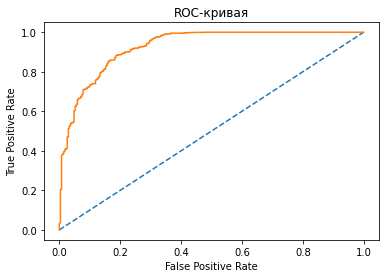

In [71]:
#Построим ROC-кривую
fpr, tpr, thresholds = metrics.roc_curve(target_test, test_predict)

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

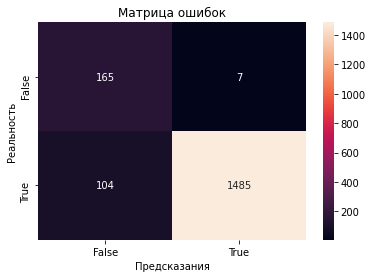

In [46]:
#Построим матрицу ошибок
predict = model_best.predict(features_test_ohe)
cf_matrix = confusion_matrix(predict, target_test)

ax = sns.heatmap(cf_matrix, annot= True , fmt="d")

ax.set_title('Матрица ошибок');
ax.set_xlabel('Предсказания')
ax.set_ylabel('Реальность');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

Text(0.5, 0, 'Важность')

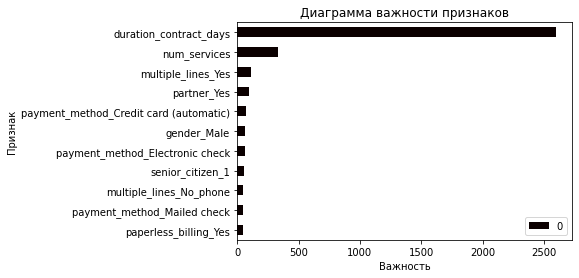

In [62]:
full_feat_importance = pd.DataFrame(model_best.best_estimator_.feature_importances_, index=features_test_ohe.columns)
full_feat_importance.sort_values(by=0).plot.barh(colormap='hot')

plt.title('Диаграмма важности признаков')
plt.ylabel('Признак')
plt.xlabel('Важность')

## Общий вывод

Данные предоставлены в 4 таблицах. Таблицы contract_new и personal_new содержат по 7043 строки без пропусков. В internet_new содержится 5517 строк без пропусков.  В таблице phone_new 6361 строка без пропущенных значений. В ходе предобработки данных явных дубликатов не выявлено. Названия столбцов приведены в соответсвие с хорошим стилем. 


Для дальнейшего исследования данных, таблицы были объедены в одну по столбцу customer_id. Количество строк в общей таблице соответвует наибольшему количеству строк из 4 таблиц (таблица contract). Типы данных некоторых столбцов изменены: total_charges переведен в float64,senior_citizen в object, begin_date и end_date в datetime64.  Для удобства работы с данными ввели столбец is_client - отражающий целевой признак: остался клиент или ушел. В ходе объединения таблиц появились пропуски. Они были заполнены значениями, исходя из назначения столбца.


В ходе исследовательского анализа данных были добавлены дополнительные столбцы с длительностью контракта в днях - duration_contract_days и количеством дополнительных услуг - num_services. Для улучшения обучения моделей были удалены столбцы:'customer_id', так как он уникальный и неколичественный, 'begin_date' и 'end_date', так как на их основе уже был создан более показательный 'duration_contract_days'.


Мы проанализировали взаимосвязь признаков на предмет мультиколлиниарности. Пороговое значение сильной коллинеарности приняли 0.6. Из численных признаков monthly_charges и total_charges сильно коррелируют со столбцами num_services и duration_contract_days, поэтому были удалены. Из категориальных признаков dependents коррелировал с partner, type с рядом других столбцов, столбцы internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies - с num_services. Данные столбцы были также удалены.


Рассмотрели балланс классов в целевом признаке. На 6 текущих клиентов приходится 1 ушедший. Дисбаланс не требует выравнивания, так как ключевая метрика AUC-ROC не чувствительна к нему.


Изучили распределение численных признаков: num_services и duration_contract_days. Аномалий не выявлено. Около 1/3 пользователей не использует доп.услуг,чуть меньше 2/3 клиентов используют 1-4 доп сервиса и небольшая часть клиентов использует 5-6 дополнительных услуг. В столбце duration_contract_days наблюдается наблюдается большое количество пользователей с маленькой длительностью котракта. С увеличением длительности контракта количество пользователей снижается и в конце на самом большом количестве дней чуть-чуть увеличивается. Скорее всего это связано с большим количеством привлеченных пользователей вначале существования мобильного оператора. 


В результате изучения категориальных признаков стало ясно: мужчин и женщин в выборке примерно по ровну; преобладают трудоспособные люди перед пенсионерами - примерно 6 к 1; в отношения состоят приблизительно половина пользователей; почти 2/3 клиентов предпочитают получать чеки в электронном виде; среди систем оплаты лидируют эллектронные чеки - около 35% клиентов предпочитают их, на остальные способы приходится приблизительно по 20% клиентов. Около 8% пользователей не имеют телефона, остальные клиенты поровну предпочитают использовать/не использовать возможность ведения параллельных линий при звонке.


Разделили датасет на обучающую и тестовую выборки. Для тестовой - выделили 25% данных. Далее были выделен целевой признак - столбец 'is_client'. Для корректного результата работы моделей методом OneHotEncoder перевели категориальные признаки в численные. Численные признаки масштабировали.

Обучили три модели  с использованием подбора гиперпараметров через GridSearchCV: LogisticRegression, CatBoostClassifier и LGBMClassifier. У модели LogisticRegression лучшее значение AUC-ROC на обучающей выборке около 0.71, у CatBoostClassifier около 0.88, у LGBMClassifier около 0.90. Таким образом, лучшая модель LGBMClassifier - с параметрами 'max_depth'=3, 'n_estimators'=550. Проверили ее на тестовой выборке - AUC-ROC около 0.93, данная модель решает поставленную задачу. 

Для анализа работы модели построили ROC-кривую. График нашей модели сильно выше чем случайной, следовательно, у нее много истинно положительных ответов и высокое качество.

Благодаря анализу важности признаков для конечной модели стало видно, что наиболее значимый признак duration_contract_days. С большим отрывом, но все еще имеющий влияние, стал признак num_services.

Из матрицы ошибок модели вытекают следующие выводы:

- TruePositive = 1485, модель отлично предсказывает пользователей, которые останутся.
- TrueNegative = 104, модель хорошо предсказывает пользователей, которые на самом деле уйдут.
- False Positive = 7, ложнооставшихся пользователей крайне мало, что отлично для нашей задачи, так как таких клиентов нужно было бы отнести в потенциально уходящие и выслать им промокод для сохранения лояльности.
- FalseNegative = 165, модель предсказывает уход пользователям, которые на самом деле останутся. Немалое количество таких предсказаний не критично, так как наша цель сохранить клиентов, и ложно высланный промокод лучше, чем невысланный действительно уходящему клиенту.


Благодаря всем вышеперечисленным этапам можно сделать вывод, что нам удалось построить модель для решения задачи классификации, которая определяет: планирует ли клиент уйти.